In [1]:
# import libraries
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import numpy as np
import torch.nn as nn
from tqdm.auto import trange, tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [6]:
# Displace the latest dataframe information
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1473 non-null   object 
 4   Si (wt.%)                        1473 non-null   float64
 5   Mn (wt.%)                        1473 non-null   float64
 6   P (wt.%)                         1473 non-null   float64
 7   S (wt.%)                         1473 non-null   float64
 8   Ni (wt.%)                        1473 non-null   float64
 9   Cr (wt.%)                        1473 non-null   float64
 10  Mo (wt.%)                        1473 non-null   float64
 11  Al (wt.%)                        1473 non-null   float64
 12  N (wt.%)            

In [7]:
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [8]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [9]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [10]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [11]:
# Select all the sub-sized type ss316  samples.
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [12]:
# check the data again.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 21 to 989
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        556 non-null    int64  
 1   Material                         556 non-null    object 
 2   Material Group                   556 non-null    object 
 3   C (wt.%)                         556 non-null    float64
 4   Si (wt.%)                        556 non-null    float64
 5   Mn (wt.%)                        556 non-null    float64
 6   P (wt.%)                         556 non-null    float64
 7   S (wt.%)                         556 non-null    float64
 8   Ni (wt.%)                        556 non-null    float64
 9   Cr (wt.%)                        556 non-null    float64
 10  Mo (wt.%)                        556 non-null    float64
 11  Al (wt.%)                        556 non-null    float64
 12  N (wt.%)                  

In [13]:
# Drop the columns that don't have  enough data records.
tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment',  'Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Ultimate Tensile Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [14]:
# Dpsplay the latest dataframe information.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 21 to 989
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                556 non-null    object 
 1   C (wt.%)                      556 non-null    float64
 2   Si (wt.%)                     556 non-null    float64
 3   Mn (wt.%)                     556 non-null    float64
 4   P (wt.%)                      556 non-null    float64
 5   S (wt.%)                      556 non-null    float64
 6   Ni (wt.%)                     556 non-null    float64
 7   Cr (wt.%)                     556 non-null    float64
 8   Mo (wt.%)                     556 non-null    float64
 9   Al (wt.%)                     556 non-null    float64
 10  N (wt.%)                      556 non-null    float64
 11  Ti (wt.%)                     556 non-null    float64
 12  Fe (wt.%)                     556 non-null    float64
 13  Nb (wt.%)

In [15]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df = tensile_df.reset_index(drop=True)
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                204 non-null    object 
 1   C (wt.%)                      204 non-null    float64
 2   Si (wt.%)                     204 non-null    float64
 3   Mn (wt.%)                     204 non-null    float64
 4   P (wt.%)                      204 non-null    float64
 5   S (wt.%)                      204 non-null    float64
 6   Ni (wt.%)                     204 non-null    float64
 7   Cr (wt.%)                     204 non-null    float64
 8   Mo (wt.%)                     204 non-null    float64
 9   Al (wt.%)                     204 non-null    float64
 10  N (wt.%)                      204 non-null    float64
 11  Ti (wt.%)                     204 non-null    float64
 12  Fe (wt.%)                     204 non-null    float64
 13  Nb (w

In [16]:
# sort the dataframe by Ultimate Tensile Strength values.
tensile_df = tensile_df.sort_values(by='Yield Strength (MPa)').reset_index(drop=True)

In [17]:
# Select columns for modeling.
input_features_df =  tensile_df.drop(columns=['Yield Strength (MPa)'])

In [18]:
# Encode the categorical columns
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [19]:
# make sure all the input data is float data type.
input_features_df = input_features_df.astype('float')

In [20]:
# define the input X and input Y values.
features = input_features_df
targets = tensile_df['Yield Strength (MPa)']

Run # 1 Fold # 1
Pearson CC: 0.9547180960810194


R2 score: 0.9080896517827752
RMSE: 66.03702442371178
MAE: 42.92303507709108


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


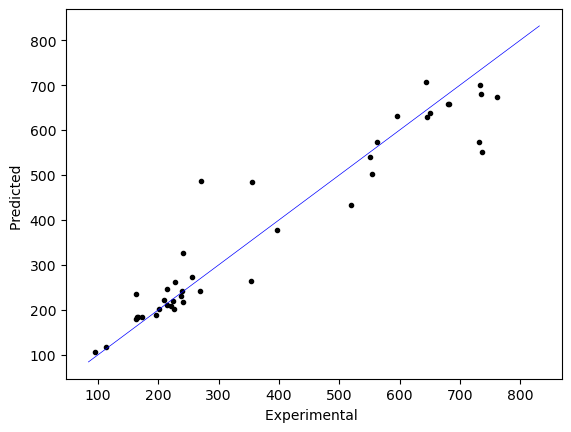

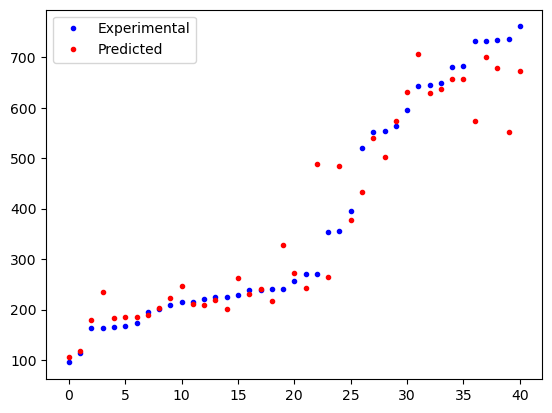

Run # 1 Fold # 2
Pearson CC: 0.9915782468037352
R2 score: 0.9799204401463139
RMSE: 32.42847911607364
MAE: 23.350364994786766


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


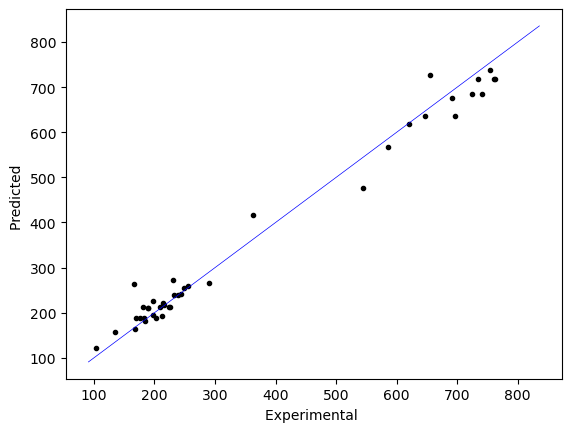

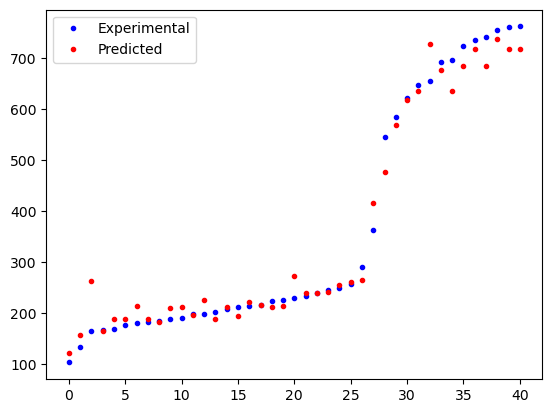

Run # 1 Fold # 3
Pearson CC: 0.9742065819134873
R2 score: 0.9464918735563286
RMSE: 48.81558284526308
MAE: 27.55985813678015


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


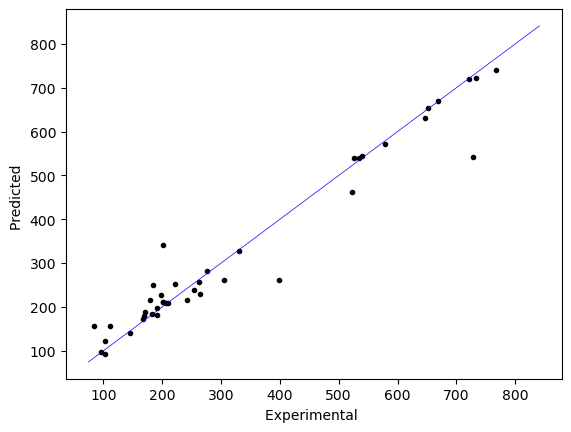

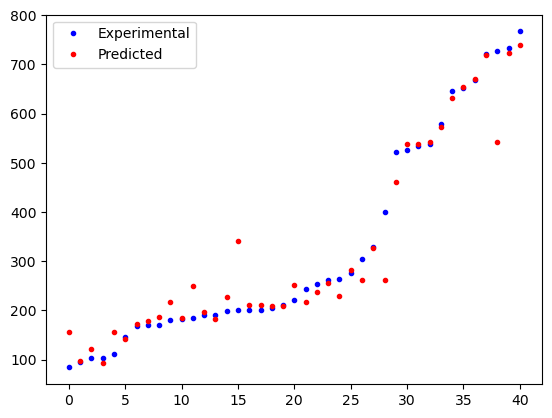

Run # 1 Fold # 4
Pearson CC: 0.9597501128378568
R2 score: 0.9145246078312398
RMSE: 55.96770261481504
MAE: 33.64358785666819


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


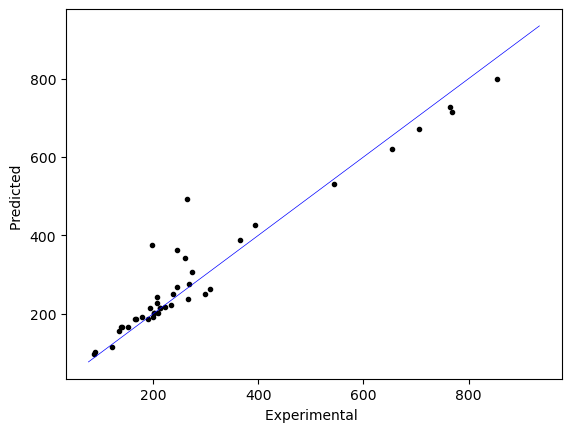

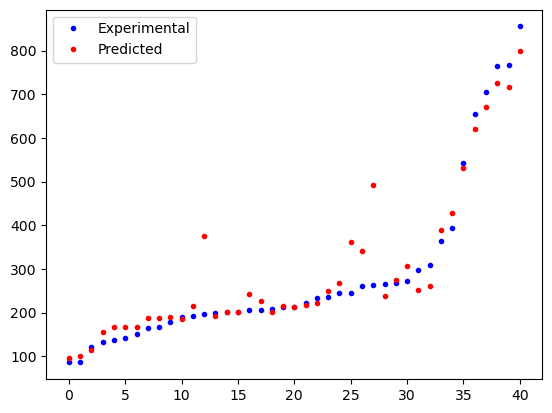

Run # 1 Fold # 5
Pearson CC: 0.9889287156626763
R2 score: 0.9703829746831455
RMSE: 37.478009316212244
MAE: 29.323143135259016


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


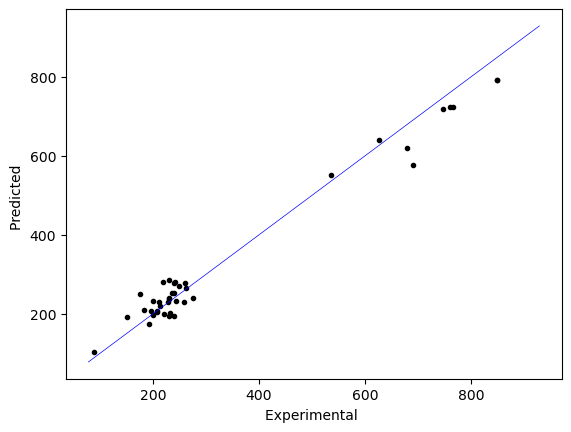

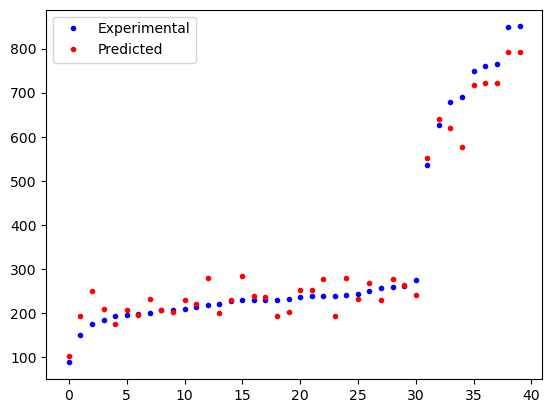

In [21]:
# XGBoost Model
import xgboost as xg


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            y_train_log = np.log10(y_train)

            # Initialize LightGBM Regressor
            xgboost_regressor = xg.XGBRegressor(objective ='reg:linear',
                                                colsample_bytree = 0.3,
                                                learning_rate = 0.1,
                                                max_depth = 5,
                                                alpha = 10,
                            n_estimators=100, seed = 123)

            # Train the model
            xgboost_regressor.fit(x_train, y_train)

            # Make predictions on the testing set
            y_pred = xgboost_regressor.predict(x_test)

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()

In [22]:
# Summary of the results dataframe
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.954718,0.908090,66.037024,42.923035
1,0.991578,0.979920,32.428479,23.350365
2,0.974207,0.946492,48.815583,27.559858
3,0.959750,0.914525,55.967703,33.643588
4,0.988929,0.970383,37.478009,29.323143


In [23]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.973836,0.014877,0.943882,0.028813,48.14536,12.186571,31.359998,6.658268


Run # 1 Fold # 1
Pearson CC: 0.9288813876924237
R2 score: 0.8553999174658994
RMSE: 82.83036225574263
MAE: 42.68794360240379


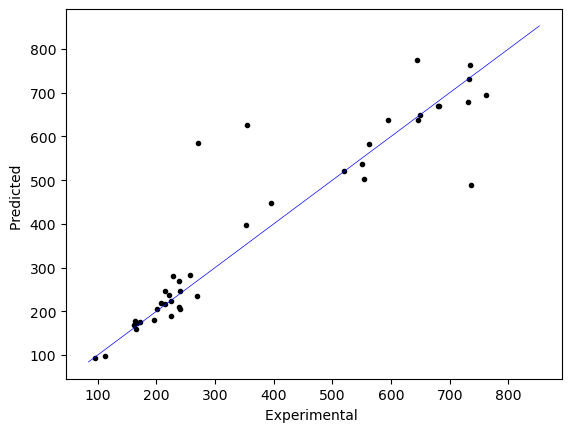

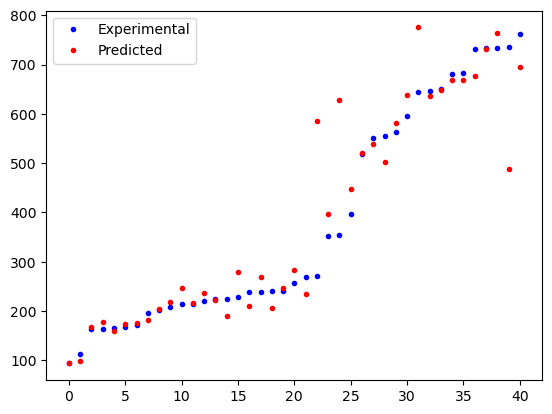

Run # 1 Fold # 2
Pearson CC: 0.9787644313886716
R2 score: 0.9565975751618677
RMSE: 47.67673247030201
MAE: 19.76651084922452


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


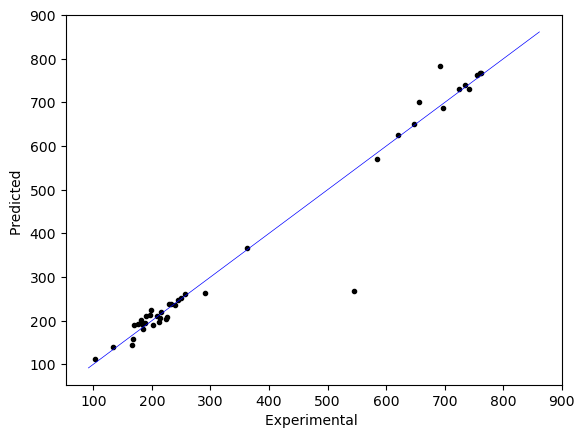

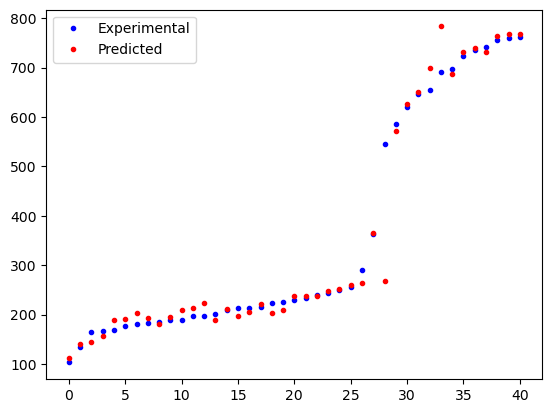

Run # 1 Fold # 3
Pearson CC: 0.9536020673385432
R2 score: 0.9076647302711944
RMSE: 64.12574412918421
MAE: 29.90569726069063


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


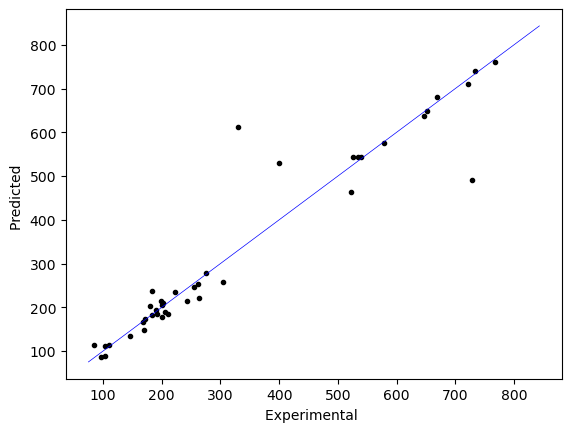

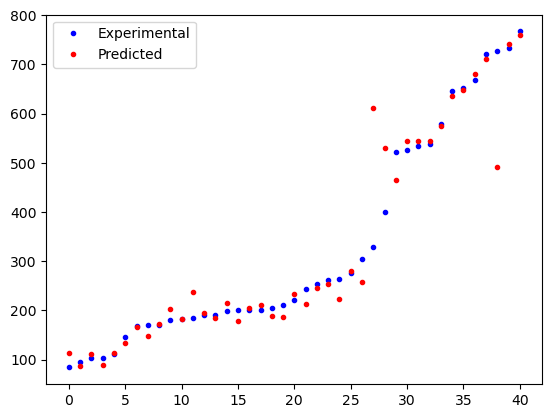

Run # 1 Fold # 4
Pearson CC: 0.9669655639513274
R2 score: 0.9337908538377706
RMSE: 49.257903406310575
MAE: 23.860622512429813


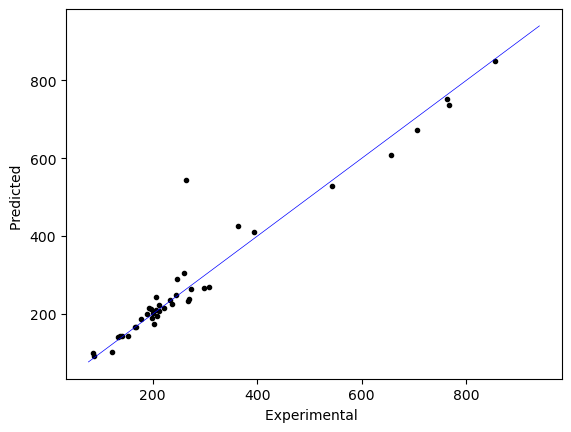

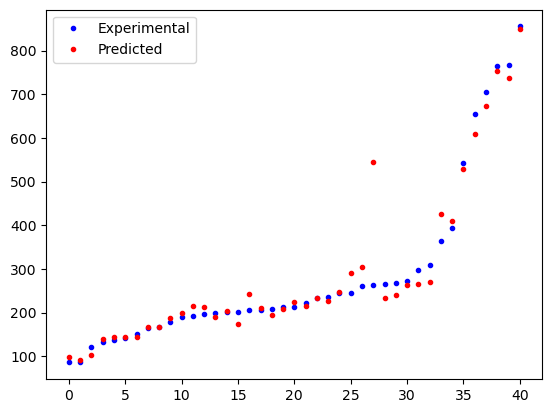

Run # 1 Fold # 5
Pearson CC: 0.9763985083692119
R2 score: 0.9522274317477876
RMSE: 47.59869997160459
MAE: 24.684823864598965


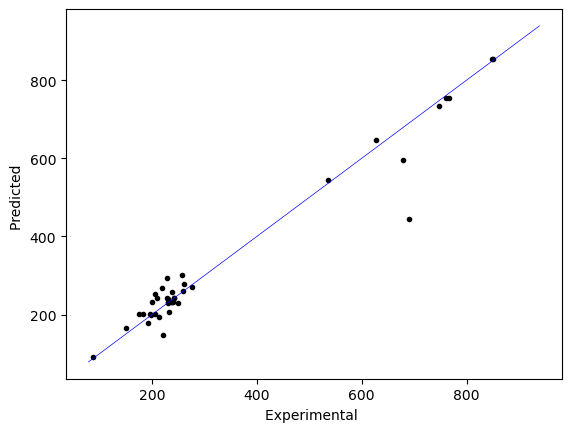

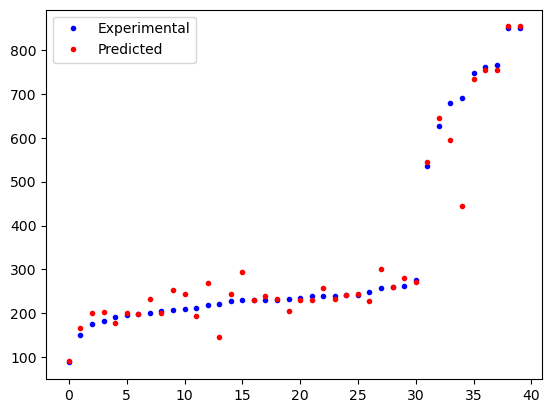

In [24]:
# Gaussian Process Regression Model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)
        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # Initialize GP Regressor
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(x_train, y_train)

            mu_z, std_z = model.predict(x_test, return_std=True)
            y_pred_test = mu_z

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred_test))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred_test))
            MAE[j, i] = mean_absolute_error(y_test, y_pred_test)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred_test, 'k.')
            bounds = (min(y_test.min(), y_pred_test.min()) - 0.1*y_pred_test.min(), max(y_test.max(), y_pred_test.max())+ 0.1 * y_pred_test.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred_test), 'r.', label='Predicted')
            plt.legend()
            plt.show()

In [25]:
# Summary of the results dataframe
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.928881,0.855400,82.830362,42.687944
1,0.978764,0.956598,47.676732,19.766511
2,0.953602,0.907665,64.125744,29.905697
3,0.966966,0.933791,49.257903,23.860623
4,0.976399,0.952227,47.598700,24.684824


In [26]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.960922,0.018301,0.921136,0.037113,58.297888,13.746338,28.18112,7.938747


Run # 1 Fold # 1
Pearson CC: 0.9863252427606771
R2 score: 0.9716060801446386
RMSE: 36.70438624600241
MAE: 25.257656901811647


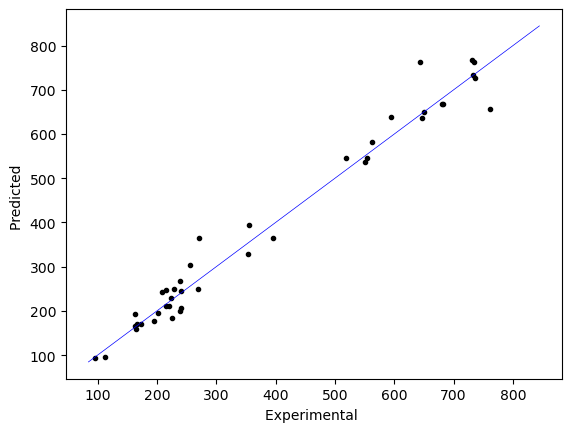

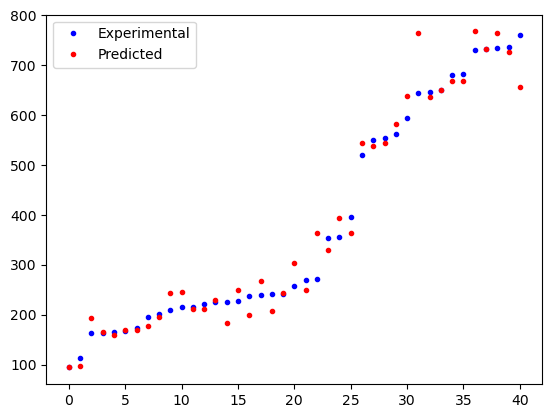

Run # 1 Fold # 2
Pearson CC: 0.9751508951026211
R2 score: 0.9495638821314394
RMSE: 51.39493391859341
MAE: 25.13137091097704


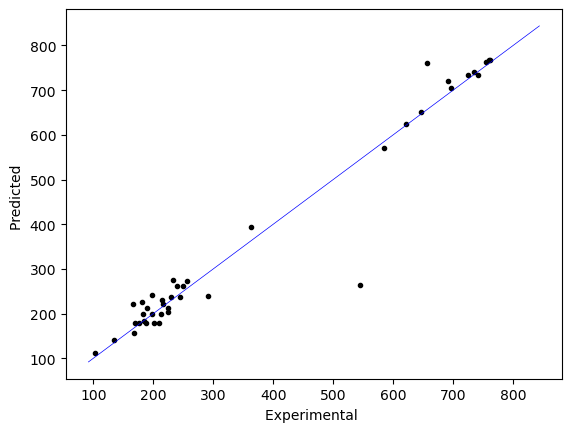

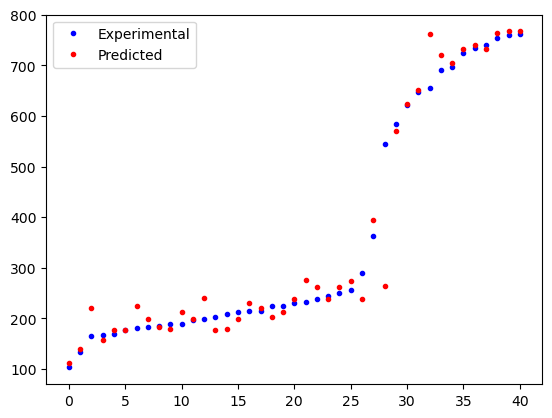

Run # 1 Fold # 3
Pearson CC: 0.9668560247910757
R2 score: 0.9302615209254779
RMSE: 55.72946097647954
MAE: 26.627532903197768


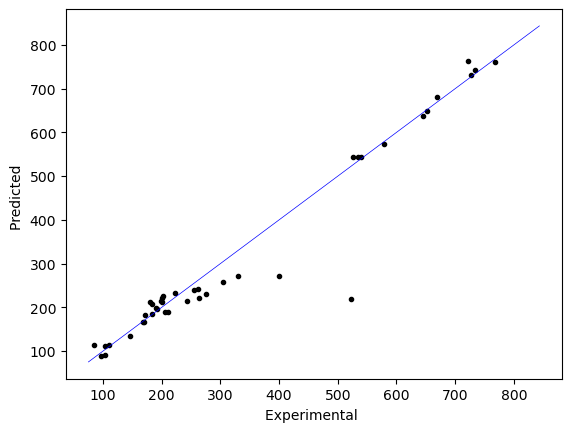

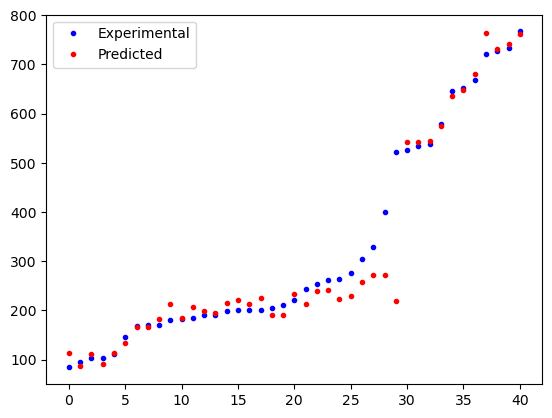

Run # 1 Fold # 4
Pearson CC: 0.9649838068485392
R2 score: 0.9311582645678822
RMSE: 50.22764708590161
MAE: 25.65562545553634


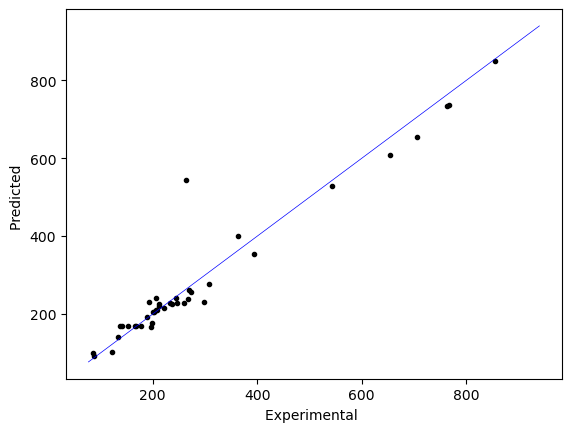

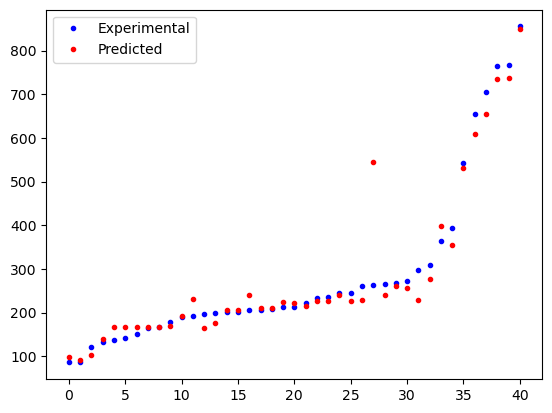

Run # 1 Fold # 5
Pearson CC: 0.9934175275502417
R2 score: 0.9863439576128576
RMSE: 25.44885367226949
MAE: 20.05613783753315


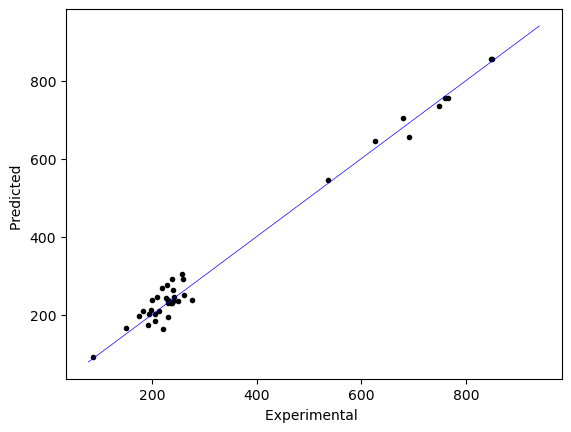

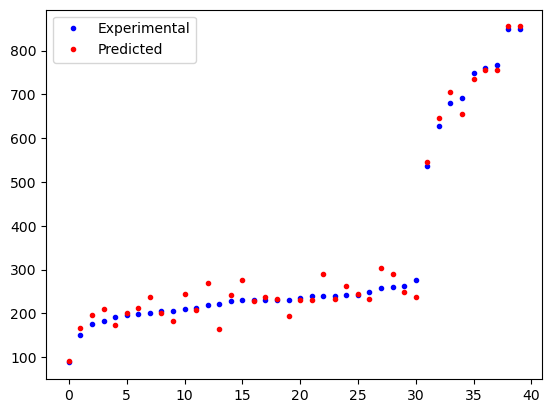

In [27]:
# Decision Tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            y_train_log = np.log10(y_train)
            y_test_log = np.log10(y_test)

            # Initialize the Decision Tree Regressor
            regressor = DecisionTreeRegressor()

            # Train the model
            regressor.fit(x_train, y_train_log)

            # Make predictions on the testing set
            y_pred = 10**(regressor.predict(x_test))

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()



In [28]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.986325,0.971606,36.704386,25.257657
1,0.975151,0.949564,51.394934,25.131371
2,0.966856,0.930262,55.729461,26.627533
3,0.964984,0.931158,50.227647,25.655625
4,0.993418,0.986344,25.448854,20.056138


In [29]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.977347,0.011015,0.953787,0.022185,43.901056,11.21045,24.545665,2.305299


Run # 1 Fold # 1
Pearson CC: 0.8595634415934706
R2 score: 0.6565704294764663
RMSE: 127.65097423297902
MAE: 71.77248130440738


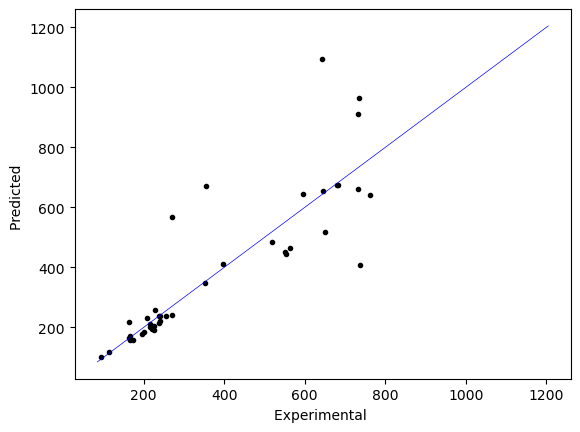

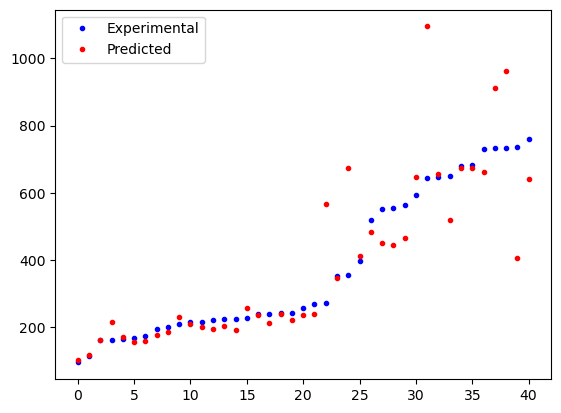

Run # 1 Fold # 2
Pearson CC: 0.931133399976784
R2 score: 0.8556247515157219
RMSE: 86.95526017298036
MAE: 53.54138964401349


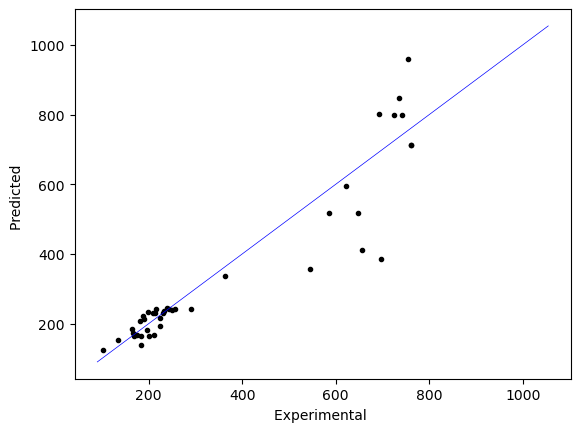

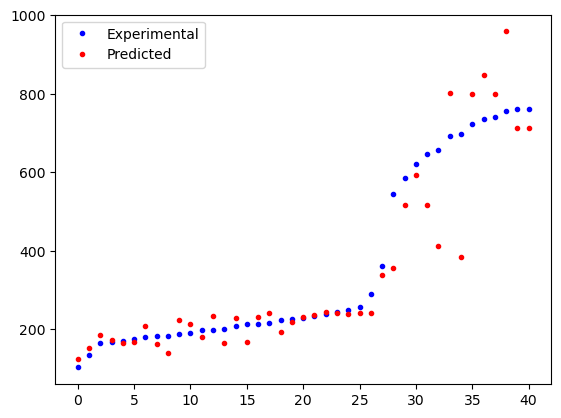

Run # 1 Fold # 3
Pearson CC: 0.9164169841780487
R2 score: 0.8362381112090342
RMSE: 85.39944063429542
MAE: 55.730881448153205


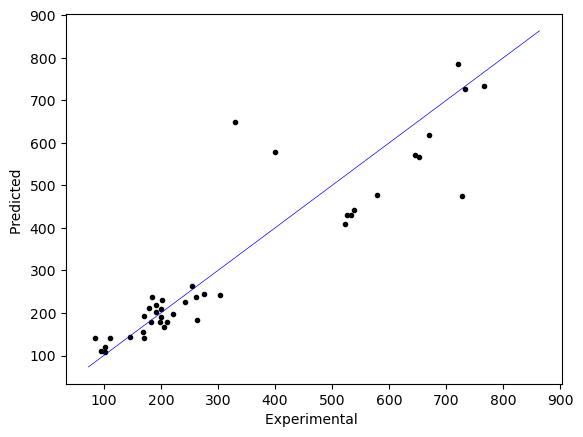

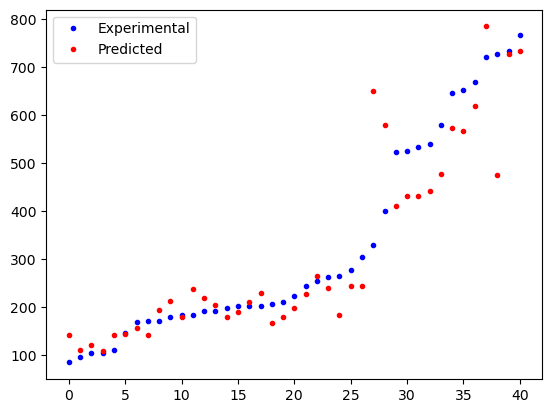

Run # 1 Fold # 4
Pearson CC: 0.9718924961385791
R2 score: 0.9154129710145058
RMSE: 55.676101093483865
MAE: 34.23474244703989


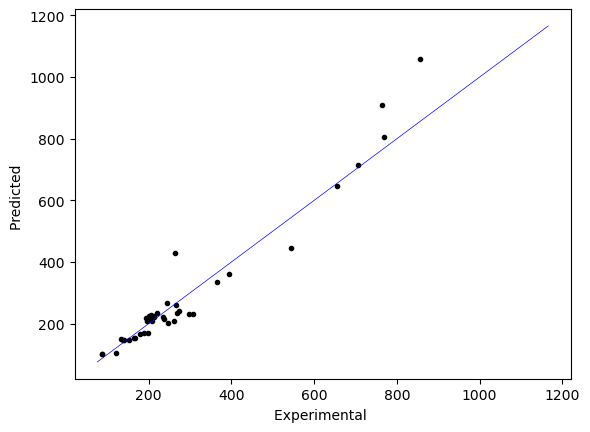

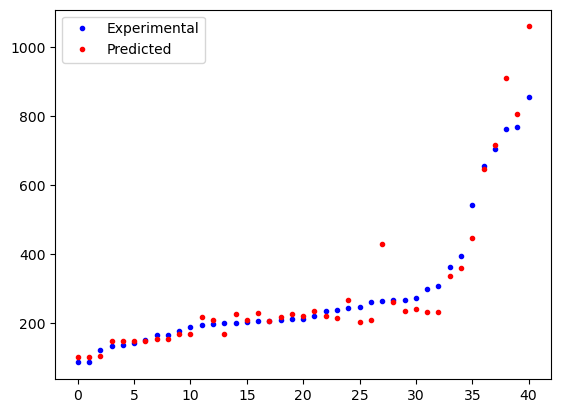

Run # 1 Fold # 5
Pearson CC: 0.9572664678834476
R2 score: 0.866715282249353
RMSE: 79.5052806298596
MAE: 48.30128717164368


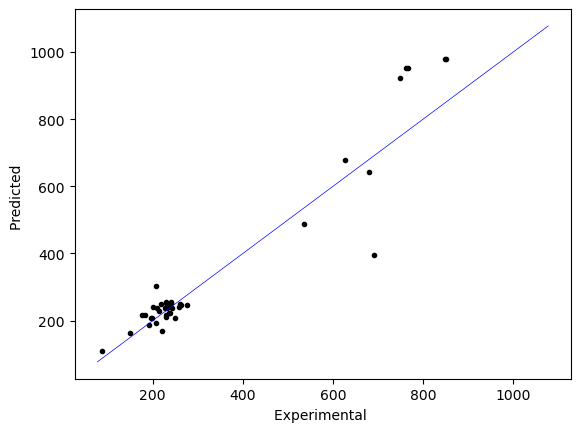

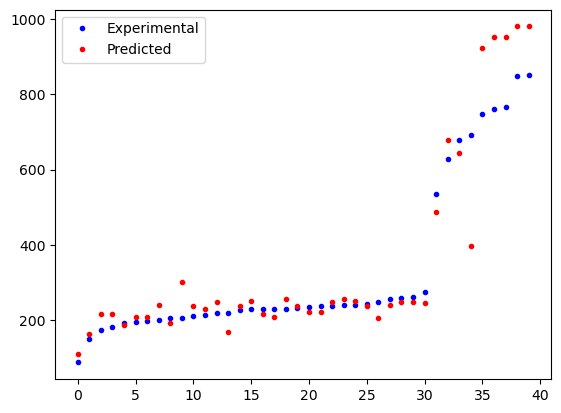

In [30]:
# SVM

from sklearn.svm import SVR

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            y_train_log = np.log10(y_train)
            y_test_log = np.log10(y_test)

            svm_regressor = SVR(kernel='linear')

            svm_regressor.fit(x_train, y_train_log)

            y_pred = 10**(svm_regressor.predict(x_test))

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()

In [31]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.859563,0.656570,127.650974,71.772481
1,0.931133,0.855625,86.955260,53.541390
2,0.916417,0.836238,85.399441,55.730881
3,0.971892,0.915413,55.676101,34.234742
4,0.957266,0.866715,79.505281,48.301287


In [32]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.927255,0.039007,0.826112,0.088703,87.037411,23.205241,52.716156,12.115831


Run # 1 Fold # 1
Pearson CC: 0.9763712639733924
R2 score: 0.9531219682540538
RMSE: 47.16175683182166
MAE: 30.408959755477774


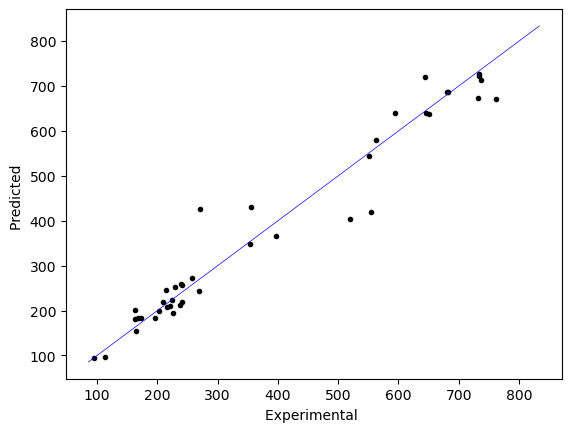

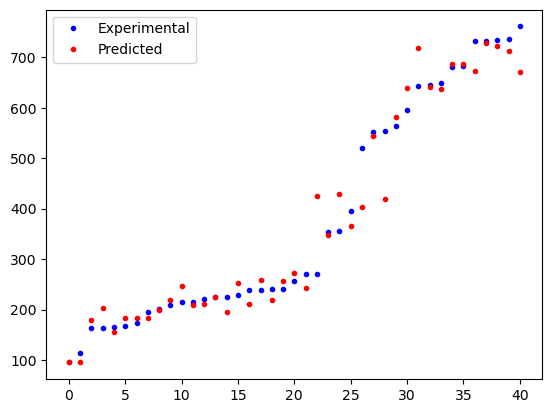

Run # 1 Fold # 2
Pearson CC: 0.9939942784001179
R2 score: 0.9875812356256745
RMSE: 25.502847859710883
MAE: 16.355905533499584


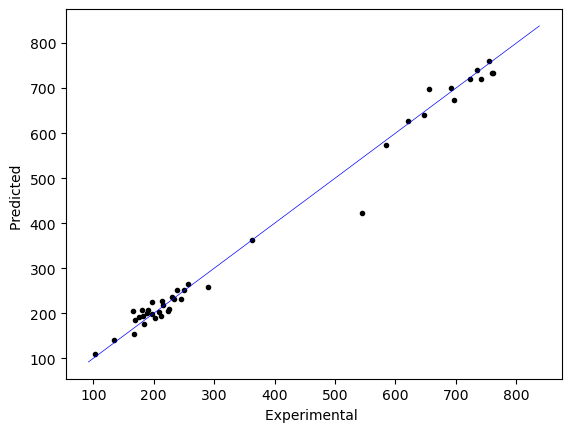

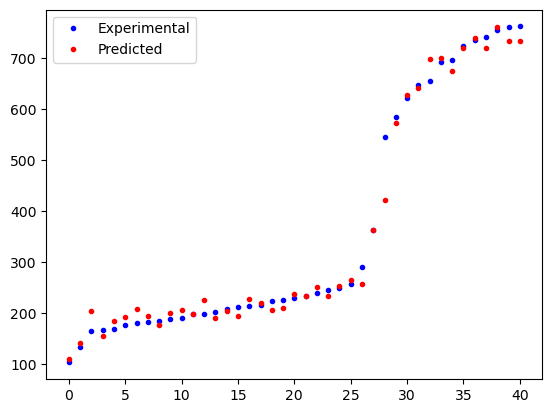

Run # 1 Fold # 3
Pearson CC: 0.9903662419964869
R2 score: 0.9799454309804698
RMSE: 29.885138531876073
MAE: 19.88297327306553


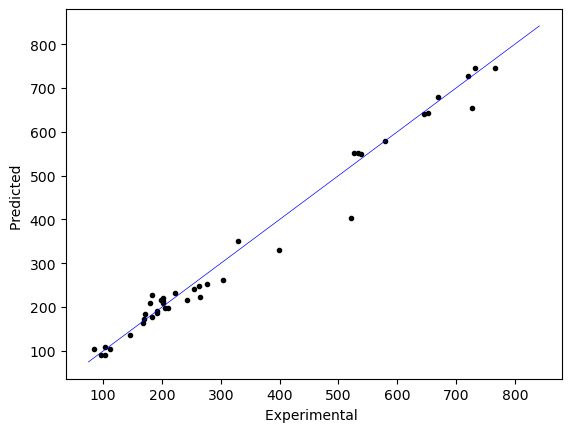

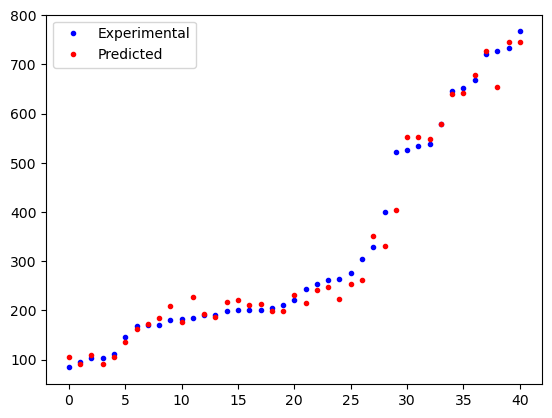

Run # 1 Fold # 4
Pearson CC: 0.9820816213761231
R2 score: 0.9638613452082775
RMSE: 36.39174832905945
MAE: 19.232221265342247


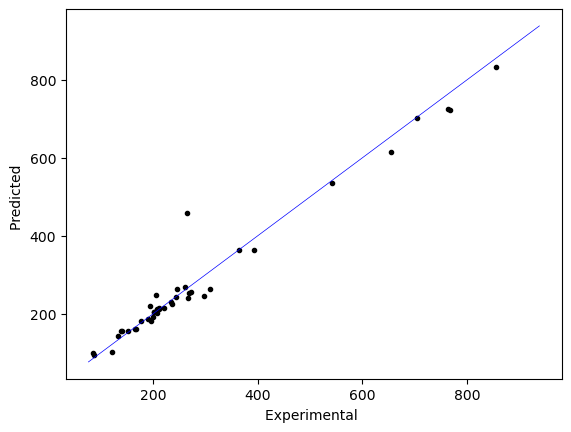

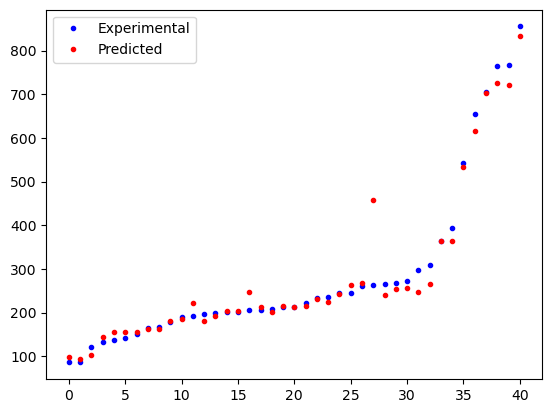

Run # 1 Fold # 5
Pearson CC: 0.9950429476019362
R2 score: 0.9891185089501691
RMSE: 22.716948899973847
MAE: 18.27967924614045


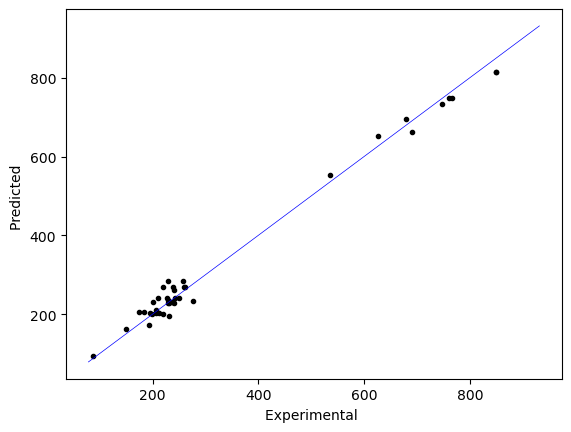

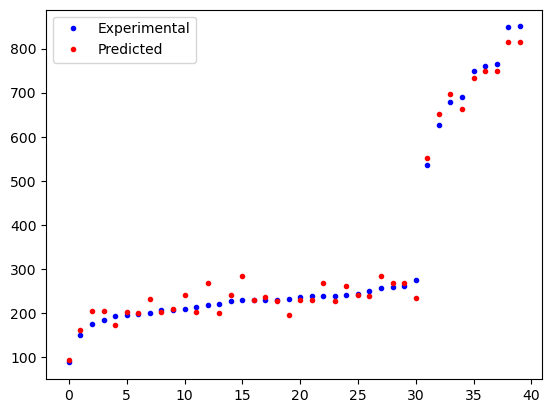

In [33]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            y_train_log = np.log10(y_train)
            y_test_log = np.log10(y_test)

            # Initialize Random Forest Regressor
            rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=123)
            # Train the model
            rf_regressor.fit(x_train, y_train_log)

            # Make predictions on the testing set
            y_pred = 10**(rf_regressor.predict(x_test))

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()


In [34]:
# Summary of the results dataframe
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.976371,0.953122,47.161757,30.408960
1,0.993994,0.987581,25.502848,16.355906
2,0.990366,0.979945,29.885139,19.882973
3,0.982082,0.963861,36.391748,19.232221
4,0.995043,0.989119,22.716949,18.279679


In [35]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.987571,0.007218,0.974726,0.014032,32.331688,8.734723,20.831948,4.934123


In [36]:
from sklearn.neighbors import KNeighborsRegressor

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
for n in range (1,11):
    print('k-neighbor:'+ str(n) )
    for j in range(nruns):

            kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

            for i, (tr, ts) in enumerate(kf.split(targets)):

                # Display the run number
                print('Run #', j+1, "Fold #", i+1)

                x_train, x_test = features.iloc[tr], features.iloc[ts]
                y_train, y_test = targets[tr], targets[ts]

                scale = StandardScaler()
                x_train = scale.fit_transform(x_train)
                x_test = scale.transform(x_test)

                y_train_log = np.log10(y_train)
                y_test_log = np.log10(y_test)

                # Initialize KNeighborsRegressor
                knn_regressor = KNeighborsRegressor(n_neighbors=n)  # You can adjust the number of neighbors (k)

                # Train the model
                knn_regressor.fit(x_train, y_train_log)

                # Make predictions on the testing set
                y_pred = 10**(knn_regressor.predict(x_test))

                # Evaluation
                R2_score[j, i] = r2_score(y_test, y_pred)
                PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
                MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
                MAE[j, i] = mean_absolute_error(y_test, y_pred)

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {MSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')


        # # Data frame
    df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                        'MAE': MAE.flatten()},index=None)
        # Calculate mean values and standard deviations of the scores
    PearsonCC_mean = np.mean(PearsonCC)
    R2_score_mean = np.mean(R2_score)
    MSE_mean = np.mean(MSE)
    MAE_mean = np.mean(MAE)

    PearsonCC_std = np.std(PearsonCC)
    R2_score_std = np.std(R2_score)
    MSE_std = np.std(MSE)
    MAE_std = np.std(MAE)

    # Data frame
    df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                    'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

    print(df2)



k-neighbor:1
Run # 1 Fold # 1


Pearson CC: 0.9193768254719228
R2 score: 0.832529305778534
RMSE: 89.14042505263191
MAE: 44.731894219628686
Run # 1 Fold # 2
Pearson CC: 0.9508408491557735
R2 score: 0.8985492009669019
RMSE: 72.89155622524969
MAE: 33.9703897684121
Run # 1 Fold # 3
Pearson CC: 0.8294370946311986
R2 score: 0.6640015393904279
RMSE: 122.3255706808796
MAE: 54.09907330933176
Run # 1 Fold # 4
Pearson CC: 0.8769286977702233
R2 score: 0.6762732311586264
RMSE: 108.91964957225333
MAE: 53.64001307994235
Run # 1 Fold # 5
Pearson CC: 0.9218073963320651
R2 score: 0.8494636818173568
RMSE: 84.49411110618362
MAE: 38.04068076921955
   Pearson CC Mean  Pearson CC Std  R2 Score Mean  R2 Score Std   MSE Mean  \
0         0.899678        0.042301       0.784163      0.095673  95.554263   

     MSE Std  MAE Mean   MAE Std  
0  17.733578  44.89641  8.093771  
k-neighbor:2
Run # 1 Fold # 1
Pearson CC: 0.8333064169509232
R2 score: 0.6847566232458677
RMSE: 122.30051215714397
MAE: 70.58556547953422
Run # 1 Fold # 2
Pearson CC: 0.9

In [37]:
# define the MyDataset object to feed the input data
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

In [38]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=38, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.25)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adagrad(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(1000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            net = MLP(hidden_dim=256, n_hidden_layers=3, use_dropout=True)

            train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_pred = np.array(net(torch.Tensor(x_test)).clone().detach().numpy())

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Run #  1 Fold # 1
Pearson CC: 0.9215373557229309
R2 score: 0.8231297019641819
RMSE: 91.60785675048828
MAE: 49.842002868652344


  0%|          | 0/1000 [00:00<?, ?it/s]

Run #  1 Fold # 2
Pearson CC: 0.9671298598048339
R2 score: 0.9248461227296693
RMSE: 62.73720932006836
MAE: 35.5465202331543


  0%|          | 0/1000 [00:00<?, ?it/s]

Run #  1 Fold # 3
Pearson CC: 0.9392409191063389
R2 score: 0.8810485803258847
RMSE: 72.78358459472656
MAE: 43.0241813659668


  0%|          | 0/1000 [00:00<?, ?it/s]

Run #  1 Fold # 4
Pearson CC: 0.9704542755086841
R2 score: 0.9399458568524165
RMSE: 46.91248321533203
MAE: 27.045392990112305


  0%|          | 0/1000 [00:00<?, ?it/s]

Run #  1 Fold # 5
Pearson CC: 0.9680588836848699
R2 score: 0.9354037540017742
RMSE: 55.34895706176758
MAE: 32.73380661010742


In [39]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.921537,0.823130,91.607857,49.842003,0.0
1,0.967130,0.924846,62.737209,35.546520,0.0
2,0.939241,0.881049,72.783585,43.024181,0.0
3,0.970454,0.939946,46.912483,27.045393,0.0
4,0.968059,0.935404,55.348957,32.733807,0.0


In [40]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)


PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)


# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.953284,0.019544,0.900875,0.044115,65.878018,15.428083,37.638381,7.982197
